In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
from scipy.io import wavfile
import sys
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import datetime
import pandas as pd
from torch.utils.data import Dataset
import torch.onnx as onnx
import torchvision.models as models
import torch.nn.functional as f

In [5]:
!pip install pydub
from pydub import AudioSegment

In [6]:
sound = AudioSegment.from_wav("/content/drive/MyDrive/lab/2021/MyTabCNN/guiter_demo.wav")
sound = sound.set_channels(1)
sound.export("/content/drive/MyDrive/lab/2021/MyTabCNN/guiter_demo_mono.wav", format="wav")

<_io.BufferedRandom name='/content/drive/MyDrive/lab/2021/MyTabCNN/guiter_demo_mono.wav'>

In [7]:
def preprocess_audio(data):
    data = data.astype(float)
    if normalize:
        data = librosa.util.normalize(data)
    if downsample:
        data = librosa.resample(data, sr_original, sr_downs)
        sr_curr = sr_downs
    if preproc_mode == "c":
        data = np.abs(librosa.cqt(data,
            hop_length=hop_length, 
            sr=sr_curr, 
            n_bins=cqt_n_bins, 
            bins_per_octave=cqt_bins_per_octave))
    elif preproc_mode == "m":
        data = librosa.feature.melspectrogram(y=data, sr=sr_curr, n_fft=n_fft, hop_length=hop_length)
    elif preproc_mode == "cm":
        cqt = np.abs(librosa.cqt(data, 
            hop_length=hop_length, 
            sr=sr_curr, 
            n_bins=cqt_n_bins, 
            bins_per_octave=cqt_bins_per_octave))
        mel = librosa.feature.melspectrogram(y=data, sr=sr_curr, n_fft=n_fft, hop_length=hop_length)
        data = np.concatenate((cqt,mel),axis = 0)
    elif preproc_mode == "s":
        data = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length))
    else:
        print ("invalid representation mode.")

    return data

In [9]:
data_path = "/content/drive/MyDrive/lab/2021/MyTabCNN/guiter_demo_mono.wav"
save_path = "/content/drive/MyDrive/lab/2021/MyTabCNN/original_data/"
sr_original, data = wavfile.read(data_path)

preproc_mode = "c"
downsample = True
normalize = True
sr_downs = 22050

cqt_n_bins = 192
cqt_bins_per_octave = 24

n_fft = 2048
hop_length = 512
sr_curr = sr_original

save_path = "/content/drive/MyDrive/lab/2021/MyTabCNN/original_data/" + preproc_mode + "/"

def preprocess_audio(data):
  data = data.astype(float)
  if normalize:
      data = librosa.util.normalize(data)
  if downsample:
      data = librosa.resample(data, sr_original, sr_downs)
      sr_curr = sr_downs
  if preproc_mode == "c":
      data = np.abs(librosa.cqt(data,
          hop_length=hop_length, 
          sr=sr_curr, 
          n_bins=cqt_n_bins, 
          bins_per_octave=cqt_bins_per_octave))
  elif preproc_mode == "m":
      data = librosa.feature.melspectrogram(y=data, sr=sr_curr, n_fft=n_fft, hop_length=hop_length)
  elif preproc_mode == "cm":
      cqt = np.abs(librosa.cqt(data, 
          hop_length=hop_length, 
          sr=sr_curr, 
          n_bins=cqt_n_bins, 
          bins_per_octave=cqt_bins_per_octave))
      mel = librosa.feature.melspectrogram(y=data, sr=sr_curr, n_fft=n_fft, hop_length=hop_length)
      data = np.concatenate((cqt,mel),axis = 0)
  elif preproc_mode == "s":
      data = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length))
  else:
      print ("invalid representation mode.")

  return data

def save_data(file, output):
  np.savez(file, output)

output = {}
output["repr"] = np.swapaxes(preprocess_audio(data),0,1)
output["label"] = np.empty(((128, 6, 21)))
#save_data(save_path + "origin.npz", output)

In [10]:
len(output["label"][0])

6

In [ ]:
loaded = np.load("/content/drive/MyDrive/lab/2021/MyTabCNN/original_data/c/origin.npz")
len(loaded["repr"])

KeyError: ignored

In [11]:
con_win_size = 9
halfwin = con_win_size // 2
loaded = output
batch_size = 128
label_dim = (6,21)

if preproc_mode == "c":
  X_dim = (batch_size, 192, con_win_size, 1)
y_dim = (batch_size, label_dim[0], label_dim[1])

X = np.empty(X_dim)
y = np.empty(y_dim)

def generator(a):
  for i in range(len(a)):
    full_x = np.pad(loaded["repr"], [(halfwin,halfwin), (0,0)], mode='constant')
    sample_x = full_x[i : i + con_win_size]
    X[i,] = np.expand_dims(np.swapaxes(sample_x, 0, 1), -1)

  return X, y

b = np.arange(1280)
b = np.reshape(b, (10, 128))
d = []
for i in b:
  c = generator(i)
  d.append(c[0])

In [12]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 64, 3)
 
        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライド

        self.drop1 = torch.nn.Dropout2d(0.25)
        self.drop2 = torch.nn.Dropout(0.5)
        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(5952,128)
        self.fc2 = torch.nn.Linear(128,126)
        
 
    def forward(self, x):
        # print(x.size())
        x = f.relu(self.conv1(x))
        # print(x.size())
        x = f.relu(self.conv2(x))
        #print(x.size())
        x = f.relu(self.conv3(x))
        #print(x.size())
        x = self.pool(x)
        #print(x.size())
        x = self.drop1(x)
        #print(x.size())
        x = self.flatten(x)
        #print(x.size())
        x = f.relu(self.fc1(x))
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        x = torch.reshape(x, (128, 6, 21)) 
        #m = nn.Softmax(dim=2)
        x_out = x
        #print(x_out.shape)
        return x_out

In [13]:
net: MyCNN = MyCNN()
net= torch.load("/content/drive/MyDrive/lab/2021/MyTabCNN/model/model.pth")
torch.save(net.state_dict(), "/content/drive/MyDrive/lab/2021/MyTabCNN/model/model_para.pth")

In [14]:
net: MyCNN = MyCNN()
criterion = torch.nn.CrossEntropyLoss()

et= torch.load("/content/drive/MyDrive/lab/2021/MyTabCNN/model/model2.pth")

net.eval()
predicts = []
for image in d:
  image = torch.Tensor(np.transpose(image, (0,3,1,2)))
  output = net(image)
  predicts.append(output)
#_, predicted = torch.max(output.data, 2)

In [15]:
answer = np.zeros((6,21))
_, predicted = torch.max(predicts[0][0], 1)
for i, gen in enumerate(predicted):
  answer[i][gen] = 1

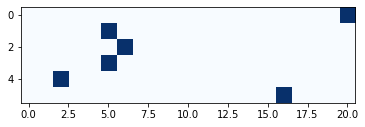

In [16]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
plt.imshow(answer, cmap=plt.cm.Blues, interpolation='nearest')
plt.show()

In [ ]:
%matplotlib nbagg
import matplotlib.pyplot as plt 

ims = []
for i in